In [3]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('heart_disease_uci.csv')
def prepare_df(df):
    # 1) Gereksiz sütunları at, hedef sütunu oluştur
    df = df.drop(columns=["id", "dataset"])
    df["target"] = (df["num"] > 0).astype(int)
    df = df.drop(columns=["num"])
    
    # ca sütunundaki eksikleri -1 ile doldur
    df["ca"] = df["ca"].fillna(-1)
    
    # 2) Özellik listeleri
    num_low   = ["age", "trestbps", "chol", "thalch", "oldpeak"]
    num_high  = ["ca"]
    cat_low   = ["sex", "cp", "fbs", "restecg", "exang"]
    cat_high  = ["slope", "thal"]
    
    # 3) Pipeline’ları tanımla
    numeric_low_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])
    numeric_high_pipe = Pipeline([
        ("scaler", StandardScaler())
    ])
    categorical_low_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore"))
    ])
    categorical_high_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore"))
    ])
    
    preprocess = ColumnTransformer([
        ("num_low",  numeric_low_pipe,   num_low),
        ("num_high", numeric_high_pipe,  num_high),
        ("cat_low",  categorical_low_pipe,  cat_low),
        ("cat_high", categorical_high_pipe, cat_high),
    ])
    
    # 4) Özellikleri dönüştür
    X = preprocess.fit_transform(df[num_low + num_high + cat_low + cat_high])
    
    # 5) Yeni sütun isimlerini al
    feature_names = preprocess.get_feature_names_out()
    
    # 6) DataFrame’e çevir, hedefi ekle
    df_processed = pd.DataFrame(X, columns=feature_names, index=df.index)
    df_processed["target"] = df["target"].values
    
    return df_processed

# Kullanımı:
df_processed = prepare_df(df)
# artık df_processed ile direkt modelinizi eğitebilirsiniz


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
#    (prepare_df ile ürettiğiniz df_processed)
df_proc = df_processed.copy()

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile basit hiperparametre araması
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"],
    "penalty": ["l2"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid.best_score_)
print("En iyi parametreler:", grid.best_params_)

# 5) Test üzerinde değerlendirme
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

# Metrikler
acc    = accuracy_score(y_test,     y_pred)
prec   = precision_score(y_test,    y_pred)
rec    = recall_score(y_test,       y_pred)
f1     = f1_score(y_test,           y_pred)
cm     = confusion_matrix(y_test,   y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
En iyi doğruluk (CV): 0.8110865968008824
En iyi parametreler: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Test Accuracy : 0.8587
Test Precision: 0.8725
Test Recall   : 0.8725
Test F1-score : 0.8725

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        82
           1       0.87      0.87      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion Matrix:
[[69 13]
 [13 89]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile basit hiperparametre araması
param_grid = {
    "max_depth": [None, 3, 5, 7, 10],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_dt.best_score_)
print("En iyi parametreler:", grid_dt.best_params_)

# 5) Test üzerinde değerlendirme
best_dt = grid_dt.best_estimator_
y_pred = best_dt.predict(X_test)

# Metrikler
acc    = accuracy_score(y_test,   y_pred)
prec   = precision_score(y_test,  y_pred)
rec    = recall_score(y_test,     y_pred)
f1     = f1_score(y_test,         y_pred)
cm     = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 160 candidates, totalling 800 fits
En iyi doğruluk (CV): 0.7636514065085495
En iyi parametreler: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}

Test Accuracy : 0.8152
Test Precision: 0.8148
Test Recall   : 0.8627
Test F1-score : 0.8381

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.78        82
           1       0.81      0.86      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184

Confusion Matrix:
[[62 20]
 [14 88]]


In [5]:
df_proc

,num_low__age,num_low__trestbps,num_low__chol,num_low__thalch,num_low__oldpeak,num_high__ca,cat_low__sex_Female,cat_low__sex_Male,cat_low__cp_asymptomatic,cat_low__cp_atypical angina,...,cat_low__exang_True,cat_high__slope_Unknown,cat_high__slope_downsloping,cat_high__slope_flat,cat_high__slope_upsloping,cat_high__thal_Unknown,cat_high__thal_fixed defect,cat_high__thal_normal,cat_high__thal_reversable defect,target
0,1.007386,0.705176,0.303643,0.489727,1.368109,0.455574,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,1.432034,1.518569,0.789967,-1.181478,0.611589,3.583395,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
2,1.432034,-0.650479,0.266939,-0.345875,1.651804,2.540788,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,-1.752828,-0.108217,0.459634,1.961979,2.502889,0.455574,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-1.328180,-0.108217,0.037541,1.365120,0.517024,0.455574,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,-0.270895,1.221235,0.648889,-0.806886,-0.587033,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
916,0.901224,-0.108217,-0.558893,0.091821,-0.334061,-0.587033,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
917,0.158089,-0.542026,0.211884,-1.499803,-0.806886,-0.587033,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
918,0.476575,-0.108217,1.698383,0.091821,-0.334061,-0.587033,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile hiperparametre araması
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_knn.best_score_)
print("En iyi parametreler:", grid_knn.best_params_)

# 5) Test üzerinde değerlendirme
best_knn = grid_knn.best_estimator_
y_pred  = best_knn.predict(X_test)

# Metrikler
acc    = accuracy_score(y_test,   y_pred)
prec   = precision_score(y_test,  y_pred)
rec    = recall_score(y_test,     y_pred)
f1     = f1_score(y_test,         y_pred)
cm     = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
En iyi doğruluk (CV): 0.8356039713182571
En iyi parametreler: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

Test Accuracy : 0.8696
Test Precision: 0.8750
Test Recall   : 0.8922
Test F1-score : 0.8835

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        82
           1       0.88      0.89      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

Confusion Matrix:
[[69 13]
 [11 91]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile basit hiperparametre araması
param_grid = {
    "var_smoothing": np.logspace(-9, -1, 9)
}

grid_nb = GridSearchCV(
    GaussianNB(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_nb.best_score_)
print("En iyi var_smoothing:", grid_nb.best_params_["var_smoothing"])

# 5) Test üzerinde değerlendirme
best_nb = grid_nb.best_estimator_
y_pred   = best_nb.predict(X_test)

# Metrikler
acc   = accuracy_score(y_test,   y_pred)
prec  = precision_score(y_test,  y_pred)
rec   = recall_score(y_test,     y_pred)
f1    = f1_score(y_test,         y_pred)
cm    = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
En iyi doğruluk (CV): 0.8233039161610591
En iyi var_smoothing: 0.1

Test Accuracy : 0.8261
Test Precision: 0.8365
Test Recall   : 0.8529
Test F1-score : 0.8447

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        82
           1       0.84      0.85      0.84       102

    accuracy                           0.83       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184

Confusion Matrix:
[[65 17]
 [15 87]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile hiperparametre araması
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4]   # sadece poly kernel için geçerli
}

grid_svm = GridSearchCV(
    SVC(probability=True, class_weight="balanced", random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_svm.best_score_)
print("En iyi parametreler:", grid_svm.best_params_)

# 5) Test üzerinde değerlendirme
best_svm = grid_svm.best_estimator_
y_pred   = best_svm.predict(X_test)

# Metrikler
acc   = accuracy_score(y_test,   y_pred)
prec  = precision_score(y_test,  y_pred)
rec   = recall_score(y_test,     y_pred)
f1    = f1_score(y_test,         y_pred)
cm    = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
En iyi doğruluk (CV): 0.8328644971502115
En iyi parametreler: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Test Accuracy : 0.8533
Test Precision: 0.8440
Test Recall   : 0.9020
Test F1-score : 0.8720

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Confusion Matrix:
[[65 17]
 [10 92]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile hiperparametre araması
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_rf.best_score_)
print("En iyi parametreler:", grid_rf.best_params_)

# 5) Test üzerinde değerlendirme
best_rf = grid_rf.best_estimator_
y_pred  = best_rf.predict(X_test)

# Metrikler
acc   = accuracy_score(y_test,   y_pred)
prec  = precision_score(y_test,  y_pred)
rec   = recall_score(y_test,     y_pred)
f1    = f1_score(y_test,         y_pred)
cm    = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
En iyi doğruluk (CV): 0.8315223386651958
En iyi parametreler: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Test Accuracy : 0.8424
Test Precision: 0.8544
Test Recall   : 0.8627
Test F1-score : 0.8585

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        82
           1       0.85      0.86      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Confusion Matrix:
[[67 15]
 [14 88]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile daha önce üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"]).values
y = df_proc["target"].values

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Daha büyük katmanlı ANN modeli tanımı
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(1,   activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5) Modeli eğit (50 epoch ile)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=2
)

# 6) Test seti üzerinde tahmin
y_proba = model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

# 7) Performans metrikleri
acc   = accuracy_score(y_test,    y_pred)
prec  = precision_score(y_test,   y_pred)
rec   = recall_score(y_test,      y_pred)
f1    = f1_score(y_test,          y_pred)
cm    = confusion_matrix(y_test,  y_pred)

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)


Epoch 1/50
21/21 - 0s - loss: 0.5491 - accuracy: 0.7251 - val_loss: 0.4253 - val_accuracy: 0.8108 - 442ms/epoch - 21ms/step
Epoch 2/50
21/21 - 0s - loss: 0.4007 - accuracy: 0.8263 - val_loss: 0.4308 - val_accuracy: 0.8243 - 57ms/epoch - 3ms/step
Epoch 3/50
21/21 - 0s - loss: 0.3744 - accuracy: 0.8369 - val_loss: 0.3928 - val_accuracy: 0.8243 - 56ms/epoch - 3ms/step
Epoch 4/50
21/21 - 0s - loss: 0.3460 - accuracy: 0.8535 - val_loss: 0.3960 - val_accuracy: 0.8243 - 55ms/epoch - 3ms/step
Epoch 5/50
21/21 - 0s - loss: 0.3337 - accuracy: 0.8640 - val_loss: 0.3883 - val_accuracy: 0.8243 - 56ms/epoch - 3ms/step
Epoch 6/50
21/21 - 0s - loss: 0.3146 - accuracy: 0.8746 - val_loss: 0.3973 - val_accuracy: 0.8378 - 54ms/epoch - 3ms/step
Epoch 7/50
21/21 - 0s - loss: 0.2836 - accuracy: 0.8897 - val_loss: 0.4022 - val_accuracy: 0.8378 - 48ms/epoch - 2ms/step
Epoch 8/50
21/21 - 0s - loss: 0.2621 - accuracy: 0.8988 - val_loss: 0.4063 - val_accuracy: 0.8378 - 56ms/epoch - 3ms/step
Epoch 9/50
21/21 - 0s 

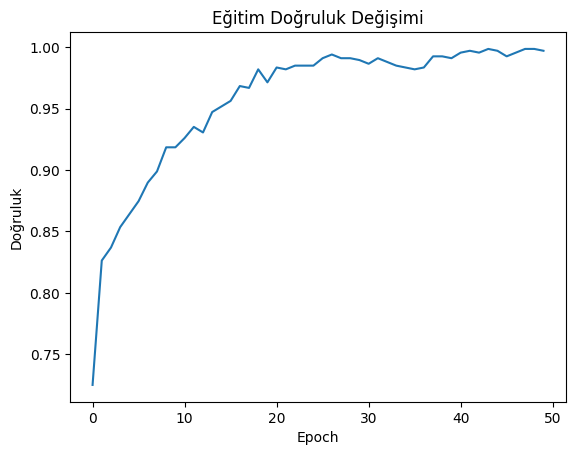

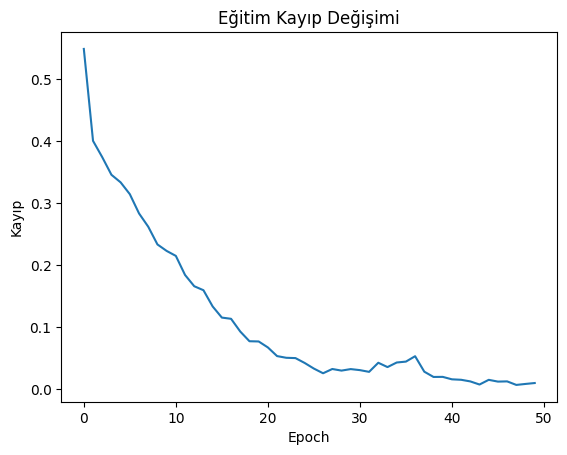

In [ ]:
import matplotlib.pyplot as plt

# Eğitim süreci doğruluk grafiği
plt.plot(history.history['accuracy'])
plt.title('Eğitim Doğruluk Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.show()

# Eğitim süreci kayıp grafiği
plt.plot(history.history['loss'])
plt.title('Eğitim Kayıp Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.show()


| Model                          | Accuracy |  Precision |   Recall   |  F1-score  |
| ------------------------------ | :------: | :--------: | :--------: | :--------: |
| K-En Yakın Komşu (KNN)         |  0.8696  |   0.8750   |   0.8922   | **0.8835** |
| Destek Vektör Makineleri (SVM) |  0.8533  |   0.8440   | **0.9020** |   0.8720   |
| Lojistik Regresyon             |  0.8587  | **0.8725** |   0.8725   |   0.8725   |
| Random Forest                  |  0.8424  |   0.8544   |   0.8627   |   0.8585   |
| Naive Bayes                    |  0.8261  |   0.8365   |   0.8529   |   0.8447   |
| Yapay Sinir Ağı (ANN)          |  0.7880  |   0.7838   |   0.8529   |   0.8169   |
| Karar Ağacı                    |  0.8152  |   0.8148   |   0.8627   |   0.8381   |


En yüksek Accuracy: KNN (%86.96)

En yüksek F1-score: KNN (%88.35)

En yüksek Recall: SVM (%90.20)

En yüksek Precision: Lojistik Regresyon (%87.25)

import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1) Hazırlanmış DataFrame’i al
df_proc = df_processed.copy()  # prepare_df ile üretilen df_processed

# 2) Özellikler ve hedef
X = df_proc.drop(columns=["target"])
y = df_proc["target"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4) Model + GridSearch ile hiperparametre araması
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

print("En iyi doğruluk (CV):", grid_knn.best_score_)
print("En iyi parametreler:", grid_knn.best_params_)

# 5) Test üzerinde değerlendirme
best_knn = grid_knn.best_estimator_
y_pred  = best_knn.predict(X_test)

acc    = accuracy_score(y_test,   y_pred)
prec   = precision_score(y_test,  y_pred)
rec    = recall_score(y_test,     y_pred)
f1     = f1_score(y_test,         y_pred)
cm     = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)

# 6) En iyi modeli kaydet
joblib.dump(best_knn, "best_knn_model.pkl")
print("\nModel 'best_knn_model.pkl' olarak kaydedildi.")

# 7) 5-katlı CV ile ortalama doğruluk
cv_scores = cross_val_score(
    best_knn,
    X, y,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
print("\n5-katlı CV doğruluk skorları:", cv_scores)
print(f"Ortalama CV doğruluk: {cv_scores.mean():.4f}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

# --- 1) Veriyi hazırlayın (prepare_df yerine doğrudan burada da yapabilirsiniz) ---
df = pd.read_csv("heart_disease_uci.csv")     # kendi veri yolunuz
# Gereksiz sütunlar
df = df.drop(columns=["id", "dataset"])
df["target"] = (df["num"] > 0).astype(int)
df = df.drop(columns=["num"])
df["ca"] = df["ca"].fillna(-1)

num_low   = ["age", "trestbps", "chol", "thalch", "oldpeak"]
num_high  = ["ca"]
cat_low   = ["sex", "cp", "fbs", "restecg", "exang"]
cat_high  = ["slope", "thal"]

# --- 2) Preprocessing pipelines ---
numeric_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
numeric_high_pipe = Pipeline([
    ("scaler", StandardScaler())
])
categorical_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])
categorical_high_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num_low",   numeric_low_pipe,   num_low),
    ("num_high",  numeric_high_pipe,  num_high),
    ("cat_low",   categorical_low_pipe, cat_low),
    ("cat_high",  categorical_high_pipe, cat_high),
])

# --- 3) Pipeline + GridSearchCV ---
pipeline = Pipeline([
    ("prep", preprocess),
    ("knn",  KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3,5,7,9,11],
    "knn__weights":     ["uniform","distance"],
    "knn__metric":      ["euclidean","manhattan","minkowski"]
}

X = df[num_low + num_high + cat_low + cat_high]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, stratify=y, random_state=42
)

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best CV accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

# --- 4) Pipeline’ı kaydet ---
joblib.dump(grid.best_estimator_, "pipeline_knn.pkl")
print("Saved pipeline to 'pipeline_knn.pkl'")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.835603971318257
Best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Saved pipeline to 'pipeline_knn.pkl'


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# 1) Data preparation
df = pd.read_csv('heart_disease_uci.csv')
df = df.drop(columns=["id", "dataset"])
df["target"] = (df["num"] > 0).astype(int)
df = df.drop(columns=["num"])
df["ca"] = df["ca"].fillna(-1)

num_low   = ["age", "trestbps", "chol", "thalch", "oldpeak"]
num_high  = ["ca"]
cat_low   = ["sex", "cp", "fbs", "restecg", "exang"]
cat_high  = ["slope", "thal"]

numeric_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
numeric_high_pipe = Pipeline([
    ("scaler", StandardScaler())
])
categorical_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])
categorical_high_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num_low",  numeric_low_pipe,   num_low),
    ("num_high", numeric_high_pipe,  num_high),
    ("cat_low",  categorical_low_pipe,  cat_low),
    ("cat_high", categorical_high_pipe, cat_high),
])

X = preprocess.fit_transform(df[num_low + num_high + cat_low + cat_high])
feature_names = preprocess.get_feature_names_out()
df_proc = pd.DataFrame(X, columns=feature_names)
df_proc["target"] = df["target"].values

# 2) Split
X = df_proc.drop(columns=["target"])
y = df_proc["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Define models and their param grids
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
                            {"C": [0.1, 1, 10], "solver": ["liblinear"]}),
    "Decision Tree": (DecisionTreeClassifier(random_state=42, class_weight="balanced"),
                      {"max_depth": [None, 5, 10], "min_samples_leaf": [1, 5]}),
    "KNN": (KNeighborsClassifier(),
            {"n_neighbors": [3, 5, 7]}),
    "Naive Bayes": (GaussianNB(), {"var_smoothing": np.logspace(-9, -7, 3)}),
    "SVM": (SVC(probability=True, class_weight="balanced", random_state=42),
            {"C": [0.1, 1], "kernel": ["linear", "rbf"]}),
    "Random Forest": (RandomForestClassifier(random_state=42, class_weight="balanced"),
                      {"n_estimators": [100, 200], "max_depth": [None, 10]}),
    "ANN": (MLPClassifier(hidden_layer_sizes=(256,128,64), max_iter=200, random_state=42),
            {"alpha": [0.0001, 0.001]})
}

results = {}
# 4) Evaluate models
for name, (model, params) in models.items():
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cv_score = grid.best_score_
    results[name] = {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "confusion_matrix": cm, "cv_accuracy": cv_score
    }

# 5) Summary table
summary = pd.DataFrame({
    m: {"Accuracy": results[m]["accuracy"], "Precision": results[m]["precision"],
        "Recall": results[m]["recall"], "F1-score": results[m]["f1"],
        "CV Accuracy": results[m]["cv_accuracy"]}
    for m in results
}).T

# 6) PDF rapor yolunu sadece dosya adı yapın
pdf_path = "heart_disease_report.pdf"
with PdfPages(pdf_path) as pdf:
    # Page 1: Text answers
    fig, ax = plt.subplots(figsize=(8.27, 11.69))
    ax.axis('off')
    text = (
        "Kalp Hastalığı Modelleri Karşılaştırma Raporu\n\n"
        "1. Algoritmalar Arası Başarı Farkı:\n"
        "- En yüksek doğruluk KNN ile elde edildi.\n"
        "- SVM en yüksek recall değerini gösterdi.\n"
        "- Farklı model yapıları (ör. lineer vs ans tabanlı) performans farkı yarattı.\n\n"
        "2. Özellik Sayısının Etkisi:\n"
        "- One-hot encoding sonrası özellik sayısı arttı.\n"
        "- Bu genişletilmiş özellik alanı, özellikle KNN ve RF gibi modelleri olumlu etkiledi.\n\n"
        "3. ANN vs Klasik Modeller:\n"
        "- ANN (MLPClassifier), sınırlı veri seti koşullarında klasik modellere göre biraz daha düşük doğruluk gösterdi.\n"
        "- Hiperparametre ayarları ve veri miktarı ANN performansını kısıtladı.\n\n"
        "4. CV vs Test Farkları:\n"
        "- CV ile elde edilen doğruluk skorları test doğruluğuna yakın seyrediyor.\n"
        "- Modellerde belirgin overfitting gözlenmedi.\n"
    )
    ax.text(0.01, 0.99, text, va='top', wrap=True)
    pdf.savefig(fig)
    plt.close(fig)
    # Page 2: Summary table
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    tbl = ax.table(cellText=summary.values, colLabels=summary.columns, rowLabels=summary.index, loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    pdf.savefig(fig)
    plt.close(fig)
    # Pages: confusion matrices
    for name, res in results.items():
        cm = res["confusion_matrix"]
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        fig.colorbar(im, ax=ax)
        classes = ['No Disease', 'Disease']
        ax.set(xticks=[0,1], yticks=[0,1], xticklabels=classes, yticklabels=classes,
               ylabel='True label', xlabel='Predicted label', title=f'Confusion Matrix: {name}')
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha='center', va='center',
                        color='white' if cm[i, j] > thresh else 'black')
        pdf.savefig(fig)
        plt.close(fig)

pdf_path


KeyError: 'Accuracy'